In [1]:
try:
    # always cd to the right directory in google colab
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/Colab Notebooks/deep_branching_with_domain"
except:
    pass

import os
import sys
import math
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from functools import partial
# add parent directory to system so that we can import the modules correctly
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from branch.galerkin import DGMNet
from branch.branch import Net

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

At the current stage, we can only deal with zero boundary condition
$$
u(t, x) = 0,
\qquad x \in \partial \Omega.
$$
For this, the usual deep branching algorithm
\begin{equation}
c(u)(t,x) = \mathbb{E} \Biggl[
1_{\{\tau_1 > T - t\}}
\frac{c(u)(T, x + W_{\nu(T-t)})}{\bar{F}(T - t)}
+ 1_{\{\tau_1 \le T - t\}}
\sum_{Z \in \mathcal{M}(c)}
\int_t^T
1_{\{I_c = Z\}}
\frac{\prod_{z \in Z}  z(u)(s,x + W_{\nu(s-t)})}{q(I_c) \rho(\tau_1)}
ds
\Biggr],
\end{equation}
is modified to
\begin{equation}
c(u)(t,x)
= \mathbb{E} \Biggl[
1_{\{\tau_1 > T - t\}}
1_{\{x + W_u \in \Omega, \ \forall 0 \le u \le \nu(T-t) \}}
\frac{c(u)(T, x + W_{\nu(T-t)})}{\bar{F}(T - t)}
+ 1_{\{\tau_1 \le T - t\}}
\sum_{Z \in \mathcal{M}(c)}
\int_t^T
1_{\{I_c = Z\}}
1_{\{x + W_u \in \Omega, \ \forall 0 \le u \le \nu(s-t) \}}
\frac{\prod_{z \in Z}  z(u)(s,x + W_{\nu(s-t)})}{q(I_c) \rho(\tau_1)}
ds
\Biggr].
\end{equation}

## The first approach
The first natural way to check for the indicator
$1_{\{x + W_u \in \Omega, \ \forall 0 \le u \le \nu(s-t) \}}$
is to discretely simulate the full path of the Brownian motion
$\{ x + W_u: u = 0, \frac{1}{m} \nu(s-t), \dots, \nu(s-t) \}$
and check only those discrete points.
This can be achieved by passing
`bm_discretization_steps=m` to the deep branching solver.

The advantage of such approach is that it allows us to deal with arbitrary domain $\Omega$.
The drawback of such approach is the longer runtime and the inaccuracy near the boundary $\partial \Omega$.

## The second approach
The second approach is to apply the tower property and
to calculate the conditional probability to survive
$$
\mathbb{E} [
1_{\{x + W_u \in \Omega, \ \forall 0 \le u < \nu(s-t) \}}
1_{\{x + W_{\nu(s-t)} \in \Omega \}} \ | \ W_{\nu(s-t)} ].
$$

In the case of the hyperrectangle
$\Omega = \prod\limits_{i=0}^{d_{in}-1} [a_i, b_i]$,
the closed form solution of the conditional probability is given by
$$
\prod\limits_{i=0}^{d_{in} - 1}
\frac{1}{\sqrt{2 \pi \nu (s-t)}}
\sum\limits_{k = -\infty}^\infty
\left(
exp\left(
    \frac{(W^{(i)}_{\nu(s-t)})^2 - (W^{(i)}_{\nu(s-t)} + 2k(b_i - a_i))^2}
    {2\nu(s-t)}
\right)
-
exp\left(
    \frac{(W^{(i)}_{\nu(s-t)})^2 - (2x + W^{(i)}_{\nu(s-t)} -2a_i + 2k(b_i - a_i))^2}
    {2\nu(s-t)}
\right)
\right),
$$
see e.g. (4.44) in [[Bor17]](#borodin2017).
This can be achieved by passing the correct formula to the deep branching solver
via `conditional_probability_to_survive`.

The advantage of such approach is the shorter runtime and the accuracy over the whole domain.
The drawback of such approach is that the formula
may not be available for domains other than the hyperrectangle.

## The formula given by Borodin

In [2]:
def conditional_probability_to_survive(
    t,
    x,
    y,
    k_arr=range(-5, 5),
    lower_bound=-10,
    upper_bound=10,
):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose (t, x, y)
    # so that the operation with lower_bound, upper_bound is correct
    t = t.unsqueeze(dim=0).transpose(0, -1)
    x, y = x.transpose(0, -1), y.transpose(0, -1)

    # calculate the probability using the formula by Borodin
    ans = 0
    for k in k_arr:
        ans += (
            torch.exp(
                ((y - x) ** 2 - (y - x + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
            - torch.exp(
                ((y - x) ** 2 - (y + x - 2*lower_bound + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
        )
    # print(ans.transpose(0, -1).prod(dim=0))
    return ans.transpose(0, -1).prod(dim=0)

def is_x_inside(x, lower_bound=-10, upper_bound=10):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose x so that the operation with lower_bound, upper_bound is correct
    x = x.transpose(0, -1)

    return (
        torch.logical_and(lower_bound <= x, x <= upper_bound)
        .transpose(0, -1).all(dim=0)
    )

## Heat equation with zero boundary condition

The heat equation
$$
\begin{cases}
& \partial_t u_A(t, x) + \frac{\nu}{2}\Delta u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \Omega,
\\
& u_A(T, x) = 1_{x \in A}, \qquad \text{for all } x \in \Omega,
\\
& u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \partial\Omega,
\end{cases}
$$
where
$A = [a, b]$
and
$\Omega = [\text{lo}, \text{hi}]$,
admits the closed-form solution of
$$
u_A(t, x) = 
\sum\limits_{k=-\infty}^\infty
 \Phi\left(\frac{b - x + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right)
- \Phi\left(\frac{a - x + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right)
- \Phi\left(\frac{b + x - 2\text{lo} + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right)
+ \Phi\left(\frac{a + x - 2\text{lo} + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right).
$$
On the other hand, when $\text{hi} \to \infty$ and $\text{lo} \to -\infty$, the solution is given by
$$
u_A(t, x) = 
\Phi\left(\frac{b - x}{\sqrt{\nu(T-t)}}\right)
- \Phi\left(\frac{a - x}{\sqrt{\nu(T-t)}}\right).
$$

In [3]:
problem_name = "heat_equation"
nu = 1
y, eps = 0, 1
a, b = y - eps, y + eps

# function definition
deriv_map = np.array([0]).reshape(-1, 1)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    """
    return torch.zeros_like(y[0])

def phi_example(x, coordinate=0):
    return torch.logical_and(x[0] <= b, x[0] >= a).float()

def exact_example(t, x, T, coordinate=0, lower_bound=-10, upper_bound=10, with_bound=False, k_arr=range(-5, 5)):
    if t == T:
        return np.logical_and(x[0] <= b, x[0] >= a)
    else:
        normal_std = math.sqrt(nu * (T - t))
        if not with_bound:
            # without bound
            return norm.cdf((b - x[0]) / normal_std) - norm.cdf((a - x[0]) / normal_std)
        else:
            # with bound
            ans = 0
            for k in k_arr:
                mu = x[0] - 2 * k * (upper_bound - lower_bound)
                ans += (norm.cdf((b - mu) / normal_std) - norm.cdf((a - mu) / normal_std))
                mu = 2 * lower_bound - 2 * k * (upper_bound - lower_bound) - x[0]
                ans -= (norm.cdf((b - mu) / normal_std) - norm.cdf((a - mu) / normal_std))
            return ans

t_lo, x_lo, x_hi = 0., -2, 2

Logs are saved in /home/nguwijy/repo/deep_branching_with_domain/logs/tmp
Patch 0: generation of u samples take 192.8606300354004 seconds.
Patch  0: epoch    0 with loss 1.11E+01
Patch  0: epoch  500 with loss 4.64E-05
Patch  0: epoch 1000 with loss 8.43E-05
Patch  0: epoch 1500 with loss 1.95E-05
Patch  0: epoch 2000 with loss 2.19E-05
Patch  0: epoch 2500 with loss 1.87E-05
Patch  0: epoch 3000 with loss 2.09E-05
Patch  0: epoch 3500 with loss 3.10E-05
Patch  0: epoch 4000 with loss 2.07E-05
Patch  0: epoch 4500 with loss 5.70E-05
Patch  0: epoch 4999 with loss 2.06E-05
Patch 0: training of u with 5000 epochs take 35.01293158531189 seconds.


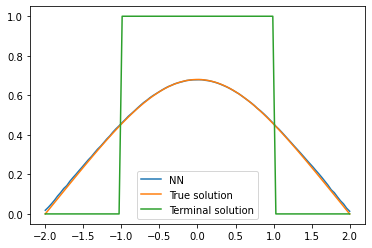

In [4]:
# based on BM discretization
patches = 1
T = patches * 1.

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    # conditional_probability_to_survive=partial(conditional_probability_to_survive, lower_bound=x_lo, upper_bound=x_hi),
    is_x_inside=partial(is_x_inside, lower_bound=x_lo, upper_bound=x_hi),
    bm_discretization_steps=500,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    overtrain_rate=0.,
    save_for_best_model=False,
    save_as_tmp=True,
)
model.train_and_eval(debug_mode=False)
model.compare_with_exact(exact_fun=partial(exact_example, lower_bound=x_lo, upper_bound=x_hi, with_bound=True))

Logs are saved in /home/nguwijy/repo/deep_branching_with_domain/logs/tmp
Patch 0: generation of u samples take 4.0043253898620605 seconds.
Patch  0: epoch    0 with loss 1.09E+01
Patch  0: epoch  500 with loss 2.14E-05
Patch  0: epoch 1000 with loss 1.47E-05
Patch  0: epoch 1500 with loss 4.72E-05
Patch  0: epoch 2000 with loss 1.43E-05
Patch  0: epoch 2500 with loss 1.44E-05
Patch  0: epoch 3000 with loss 1.43E-05
Patch  0: epoch 3500 with loss 1.95E-04
Patch  0: epoch 4000 with loss 1.53E-05
Patch  0: epoch 4500 with loss 2.32E-05
Patch  0: epoch 4999 with loss 1.72E-05
Patch 0: training of u with 5000 epochs take 34.86519742012024 seconds.


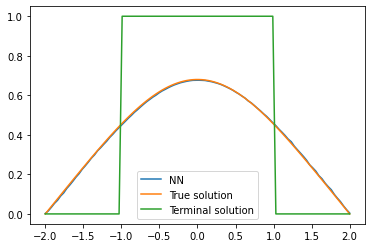

In [5]:
# based on the formula by Borodin
patches = 1
T = patches * 1.

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(conditional_probability_to_survive, lower_bound=x_lo, upper_bound=x_hi),
    is_x_inside=partial(is_x_inside, lower_bound=x_lo, upper_bound=x_hi),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    overtrain_rate=0.,
    save_for_best_model=False,
    save_as_tmp=True,
)
model.train_and_eval(debug_mode=False)
model.compare_with_exact(exact_fun=partial(exact_example, lower_bound=x_lo, upper_bound=x_hi, with_bound=True))

## References
<a id="borodin2017">[Bor17]</a>
A. N. Borodin.
Stochastic processes.
*Cham: Birkhäuser*, 2017.